In [1]:
from lma.jupyter.setupJupyter import setupJupyter; setupJupyter(plotStyle='paper') #plotTheme='light',

In [2]:
import h5py

ptha = Path('/Users/tel/roberts_lab/projects/FFluxValidation/sweeps/sim_bf/name_gts_-_sim_bf_-_samples_1e11_-_basin_A/theta_1.0e-01/oparamHist_-_numExecs_44.lmint')
pthb = Path('/Users/tel/roberts_lab/projects/FFluxValidation/sweeps/sim_bf/name_gts_-_sim_bf_-_samples_1e11_-_basin_B/theta_1.0e-01/oparamHist_-_numExecs_44.lmint')

h = []
e = []
for pth in (ptha, pthb):
    with h5py.File(pth, 'r') as f:
        harr = np.zeros(f['OParamHists/Sum/h'].shape)
        earr = np.zeros(f['OParamHists/Sum/h_edges'].shape)
        h.append(harr)
        e.append(earr)
        
        f['OParamHists/Sum/h'].read_direct(harr)
        f['OParamHists/Sum/h_edges'].read_direct(earr)
        
_hsum = h[0] + h[1]
hsum = _hsum[1:, 1:]
edges = [e[0][:len(e[0])//2], e[0][len(e[0])//2:]]

X,Y = np.meshgrid(*edges)

In [16]:
from copy import deepcopy
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

def cmapbad(cmap):
    """Modifies a named cmap so that its bad values become its smallest
    """
    if isinstance(cmap, str): cmap = mpl.cm.get_cmap(cmap)
    
    cmap = deepcopy(cmap)
    cmap.set_bad(cmap(0))
    return cmap
    
def resamplehist(arr, n=None):
    if n is None:
        return arr
    
    p = arr.ravel()
    p /= p.sum()
    res = np.random.multinomial(int(n), p)
    return res.reshape(hsum.shape)

def plothist(h, e, xlim=None, ylim=None, cbar=False, cmap='viridis', title='', cbarlabel='probability', 
             xlabel='', ylabel='', fig=None, ax=None, **kwargs):
    cmap = cmapbad(cmap)
    if fig is None and ax is None: fig,ax = pltHlp.figAx()
    
    X,Y = np.meshgrid(*e)
    img = ax.pcolormesh(X,Y,h/h.sum(), norm=mpl.colors.LogNorm(), cmap=cmap, **kwargs)
    
    
    if cbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        # create the colorbar 
        cbar = fig.colorbar(img, ax=ax, cax=cax)
        # cbar.set_ticks([0, .2, .4, .6, .8, 1])
        cbar.set_label(cbarlabel, rotation=270, labelpad=15, fontsize=16)
#     else:
#         cax.remove()
    
    if xlim: ax.set_xlim(*xlim)
    if ylim: ax.set_ylim(*ylim)
    
    ax.set_xlabel(xlabel)#, fontsize=16)
    ax.set_ylabel(ylabel)#, fontsize=16)
    ax.set_title(title)#, fontsize=20)
    
    ax.set_aspect('equal', 'box')
    
    return fig, ax, img

In [5]:
def gettime(dt, unit, unitorig='s'):
    if not isinstance(dt, np.timedelta64): dt = np.timedelta64(dt, unitorig)
    return dt / np.timedelta64(1, unit).astype(dt.dtype)

ns = (np.logspace(5,9, num=3)*4).tolist() + [None]
samps = [resamplehist(hsum, n) for n in ns]

cputime = (np.datetime64('2015-08-23 16:15:41') - np.datetime64('2015-08-21 23:53:09'))*28*24
cputime.astype('timedelta64[Y]')

samptimes = [cputime*(n/hsum.sum()) if n is not None else cputime for n in ns]

units = ['m', 'h', 'D', 'Y']
unitlabels = ['minutes', 'hours', 'days', 'years']
samptimeunits = [gettime(st, u) for st,u in zip(samptimes,units)]

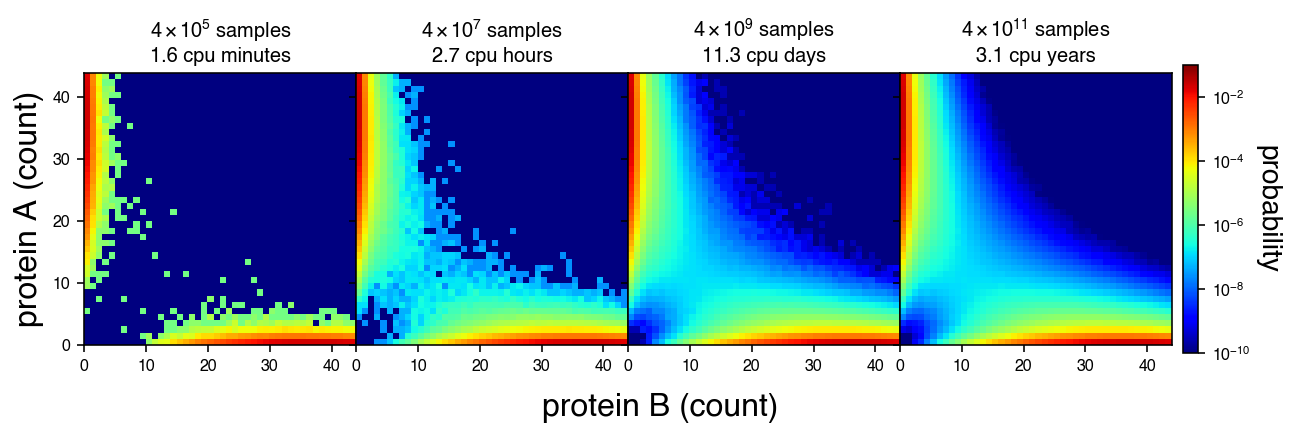

In [46]:
xlabel = 'protein B (count)'
ylabel = 'protein A (count)'
cbarlabel = 'probability'

fig,axarr = pltHlp.figAxArr([1, len(samps)], sharey=True) #, gridspec_kw={'wspace': -.2})
labelAxes = fig.add_subplot(111) #fig.add_axes([0,0,1,1])
labelAxes.zorder = -1

# for axis in ph.axisList(labelAxes):
#     ph.setTickLabelFreq(axis, start=999)

# make the figure titles
titles = [r'$4 \times 10^{%d}$' ' samples\n%.1f cpu %s' % (int(np.log10(samp.sum())), stu, ulab)
           for samp,stu,ulab in zip(samps, samptimeunits, unitlabels)]

for n,samp,title,ax in zip(ns, samps, titles, axarr.flat):
    kwargs = dict([
        ('xlim', (0,44)),
        ('ylim', (0,44)),
        ('fig', fig),
        ('ax', ax),
        ('title', title),
        ('vmin', 1e-10), #10**-11.301),
        ('vmax', 1e-01)  #10**-1.638)
    ])
        
    _,_,img = plothist(samp, edges, cmap='jet', **kwargs)

# divider = make_axes_locatable(labelAxes)
# cax = divider.append_axes("right", size="2%", pad=0.2)
cbar = fig.colorbar(img, ax=axarr[-1], fraction=0.046, pad=0.01)#, cax=cax)

labelAxes.set_xlabel(xlabel, labelpad=20, fontsize=16)
labelAxes.set_ylabel(ylabel, labelpad=20, fontsize=16)
cbar.set_label(cbarlabel, rotation=270, labelpad=15, fontsize=14)

ph.hideAxesFrame(labelAxes)
ph.savefig(fig, 'gts_theta_1en1_landscape_2d_comparison_samples', '../../figures/')
pass

In [26]:
hsumnorm = hsum/hsum.sum()
np.log10(hsumnorm[hsumnorm > 0].min())

-11.30103000434987

In [24]:
np.log10(cbar.vmax)

-1.638117028380714

In [11]:
def alltrace(arr):
    """produces an array of the trace along every diagonal of a matrix
    """
    r,c = arr.shape
    diag_idx = np.arange(r)[:, None] - (np.arange(c) - (c - 1))
    return np.bincount(diag_idx.ravel(), weights=arr.ravel())

def to1d(h=None, e=None):
    # take the trace of every diagonal
    ret = (None if h is None else alltrace(h),)
    
    # reverse the first edges, crop the first value of the 2nd, then cat them
    ret += (None if e is None else np.concatenate([-e[0][:0:-1], e[1]]),)
    
    return ret

edges1d = to1d(e=edges)[1]
samps1d = [to1d(h=s)[0] for s in samps]

In [15]:
mpl.rcParams['figure.figsize']

[2.0, 2.0]

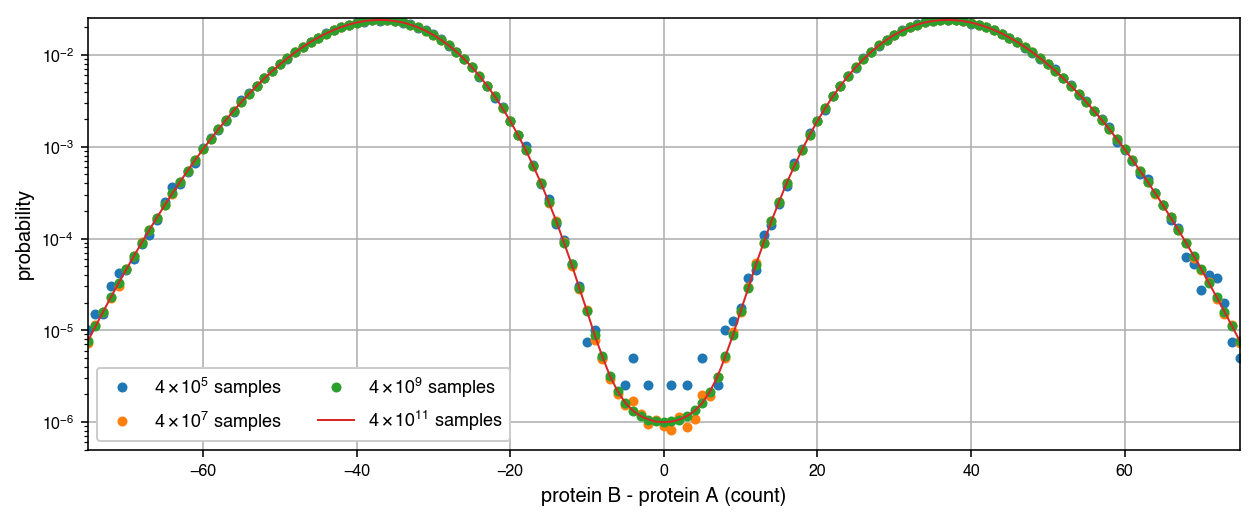

In [67]:
xlabel = 'protein B - protein A (count)'
ylabel = 'probability'
labels = [r'$4 \times 10^{%d}$' ' samples' % int(np.log10(samp.sum())) for samp in samps]

widesize = mpl.rcParams['figure.figsize'] * np.array([4, 1.5])
fig,ax = ph.figAx(figsize=widesize)

for i,(s1d,lab) in enumerate(zip(samps1d, labels)):
    if i == len(samps1d) - 1:
        ax.plot(edges1d, s1d/s1d.sum(), label=lab, lw=1)
    else:
        ax.plot(edges1d, s1d/s1d.sum(), label=lab, marker='.', ls='None')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

ax.set_xlim(-75, 75)
ax.set_ylim(5e-7)  #, 5e-5)
ax.set_yscale('log')
ax.grid()
ax.legend(ncol=2)

ph.savefig(fig, 'gts_theta_1en1_landscape_1d_comparison_samples', '../../figures/')
pass

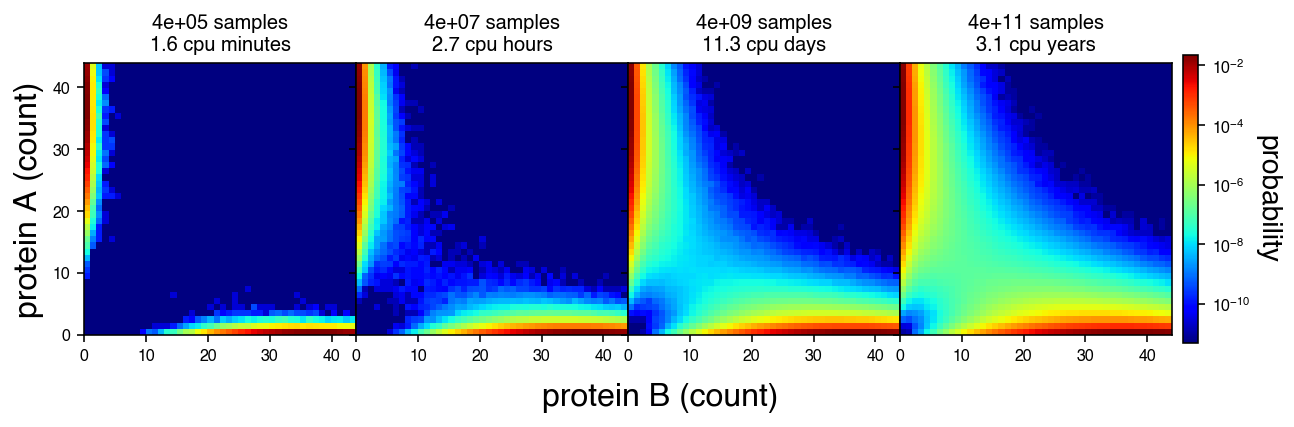

In [12]:
fig,axarr = pltHlp.figAxArr([1, len(samps)], sharey=True) #, gridspec_kw={'wspace': -.2})
labelAxes = fig.add_subplot(111) #fig.add_axes([0,0,1,1])
labelAxes.zorder = -1

# for axis in ph.axisList(labelAxes):
#     ph.setTickLabelFreq(axis, start=999)

xlabel = 'protein B (count)'
ylabel = 'protein A (count)'
cbarlabel = 'probability'

# make the figure titles
titles = ['%.0e samples\n%.1f cpu %s' % (samp.sum(), stu, ulab)
           for samp,stu,ulab in zip(samps, samptimeunits, unitlabels)]

for n,samp,title,ax in zip(ns, samps, titles, axarr.flat):
    kwargs = dict([
        ('xlim', (0,44)),
        ('ylim', (0,44)),
        ('fig', fig),
        ('ax', ax),
        ('title', title)
    ])
        
    _,_,img = plothist(samp, edges, cmap='jet', **kwargs)

# labelAxes.spines['top'].set_color('none')
# labelAxes.spines['bottom'].set_color('none')
# labelAxes.spines['left'].set_color('none')
# labelAxes.spines['right'].set_color('none')
# labelAxes.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# divider = make_axes_locatable(labelAxes)
# cax = divider.append_axes("right", size="2%", pad=0.2)
cbar = fig.colorbar(img, ax=axarr[-1], fraction=0.046, pad=0.01)#, cax=cax)

labelAxes.set_xlabel(xlabel, labelpad=20, fontsize=16)
labelAxes.set_ylabel(ylabel, labelpad=20, fontsize=16)
cbar.set_label(cbarlabel, rotation=270, labelpad=15, fontsize=14)

ph.hideAxesFrame(labelAxes)
ph.savefig(fig, 'gts_theta_1en1_2d_landscape_comparison_samples', '../../figures/')
pass

In [10]:
ph

<module 'lma.src.helper.plotHelper' from '/Users/tel/git/lma/lma/src/helper/plotHelper.py'>

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

In [86]:
%debug

> <ipython-input-85-44bc479803df>(17)<module>()
     15 #         kwargs['cbar'] = True
     16 
---> 17     fig,ax,img = plothist(samp, edges, **kwargs)
     18 
     19 ax = fig.add_subplot(111)



ipdb>  plothist(samp, edges, **kwargs)


(<Figure size 1200x300 with 4 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x302b07c18>)


ipdb>  exit


In [65]:
np.logspace(5,9, num=3)

array([1.e+05, 1.e+07, 1.e+09])

In [64]:
np.log10(hsum.sum())

11.602060000013852

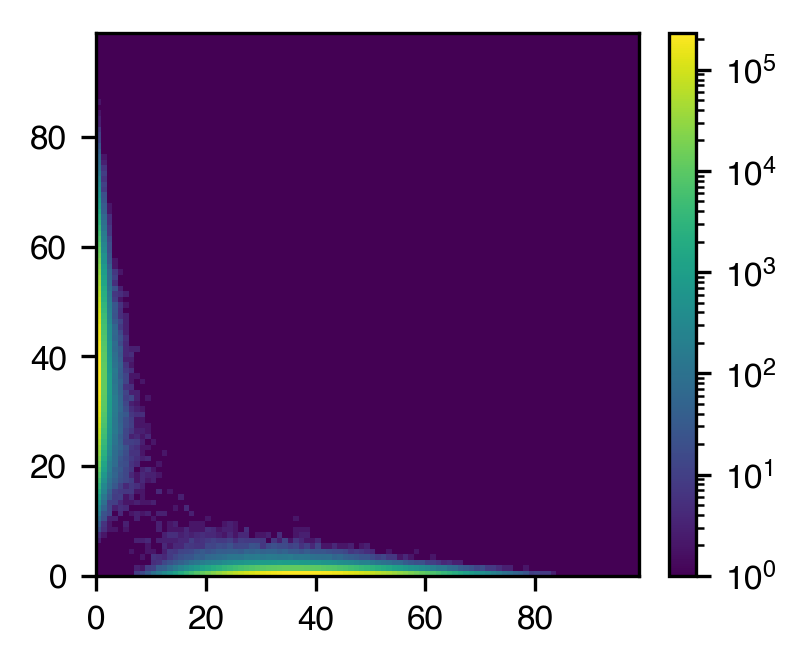

In [59]:




# ensure that x vs y scaling doesn't disrupt the transforms applied to the 2D gaussian



In [53]:
res.sum()

100000

In [ ]:
def resampFlat(arr, reps):
    n = arr.shape[-1]

    # create an array to shift random indexes as needed
    shift = np.repeat(np.arange(0, arr.size, n), n).reshape(arr.shape)

    # get a flat view of the array
    arrflat = arr.ravel()
    # sample the array by generating random ints and shifting them appropriately
    return np.array([arrflat[np.random.randint(0, n, arr.shape) + shift] 
                     for i in range(reps)])

In [24]:
_hsum

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   4.,   6., ..., 170., 192.,  70.],
       [  0.,  12.,  14., ...,   2.,   6.,   0.],
       ...,
       [  0., 150.,   4., ...,   0.,   0.,   0.],
       [  0., 110.,   4., ...,   0.,   0.,   0.],
       [  0., 102.,   0., ...,   0.,   0.,   0.]])

In [23]:
hsum

array([[  4.,   6., 350., ..., 170., 192.,  70.],
       [ 12.,  14., 196., ...,   2.,   6.,   0.],
       [278., 178., 434., ...,   0.,   0.,   0.],
       ...,
       [150.,   4.,   0., ...,   0.,   0.,   0.],
       [110.,   4.,   0., ...,   0.,   0.,   0.],
       [102.,   0.,   0., ...,   0.,   0.,   0.]])

In [20]:
e = [e[0][:len(e[0])//2]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

In [5]:
from lma.example.compareBFFFluxHists import CompareBFFFlux,CompareBFFFluxHists

In [3]:
bfRootPath = Path('/Users/tel/roberts_lab/projects/FFluxValidation/sweeps/sim_bf')

comp = CompareBFFFluxHists(bfRootPath=bfRootPath, lmintOnly=True)

KeyError: frozenset({('samples', '1e9'), ('basin', 'A')})

In [7]:
sims = CompareBFFFlux(bfRootPath=bfRootPath, lmintOnly=True)

In [ ]:
sims.bfSims

> /Users/tel/git/lma/lma/src/magicDict/magicDict.py(285)_getattr()
    283             from IPython.core.debugger import Pdb; Pdb().set_trace()
    284             # make no assumptions about the reason things went wrong
--> 285             raise AttributeError("Could not fetch requested attribute from any object(s) contained in MagicDict md.\n" 
    286                                  "attribute: %s, md: %s" % (name, self))
    287 



ipdb>  l


    280             #     # assume we're here because a tag was unrecognized during a .select call
    281             #     raise _SelectError()
    282             # elif doRaise:
    283             from IPython.core.debugger import Pdb; Pdb().set_trace()
    284             # make no assumptions about the reason things went wrong
--> 285             raise AttributeError("Could not fetch requested attribute from any object(s) contained in MagicDict md.\n" 
    286                                  "attribute: %s, md: %s" % (name, self))
    287 
    288     def getattr(self, name, doRaise=False):
    289         """returns a copy of self with the values replaced by value.name
    290 



ipdb>  c


> /Users/tel/git/lma/lma/src/magicDict/magicDict.py(285)_getattr()
    283             from IPython.core.debugger import Pdb; Pdb().set_trace()
    284             # make no assumptions about the reason things went wrong
--> 285             raise AttributeError("Could not fetch requested attribute from any object(s) contained in MagicDict md.\n" 
    286                                  "attribute: %s, md: %s" % (name, self))
    287 



ipdb>  exit


> /Users/tel/git/lma/lma/src/magicDict/magicDict.py(285)_getattr()
    283             from IPython.core.debugger import Pdb; Pdb().set_trace()
    284             # make no assumptions about the reason things went wrong
--> 285             raise AttributeError("Could not fetch requested attribute from any object(s) contained in MagicDict md.\n" 
    286                                  "attribute: %s, md: %s" % (name, self))
    287 



ipdb>  exit


> /Users/tel/git/lma/lma/src/magicDict/magicDict.py(285)_getattr()
    283             from IPython.core.debugger import Pdb; Pdb().set_trace()
    284             # make no assumptions about the reason things went wrong
--> 285             raise AttributeError("Could not fetch requested attribute from any object(s) contained in MagicDict md.\n" 
    286                                  "attribute: %s, md: %s" % (name, self))
    287 



ipdb>  exit


> /Users/tel/git/lma/lma/src/magicDict/magicDict.py(285)_getattr()
    283             from IPython.core.debugger import Pdb; Pdb().set_trace()
    284             # make no assumptions about the reason things went wrong
--> 285             raise AttributeError("Could not fetch requested attribute from any object(s) contained in MagicDict md.\n" 
    286                                  "attribute: %s, md: %s" % (name, self))
    287 



ipdb>  exit


> /Users/tel/git/lma/lma/src/magicDict/magicDict.py(285)_getattr()
    283             from IPython.core.debugger import Pdb; Pdb().set_trace()
    284             # make no assumptions about the reason things went wrong
--> 285             raise AttributeError("Could not fetch requested attribute from any object(s) contained in MagicDict md.\n" 
    286                                  "attribute: %s, md: %s" % (name, self))
    287 



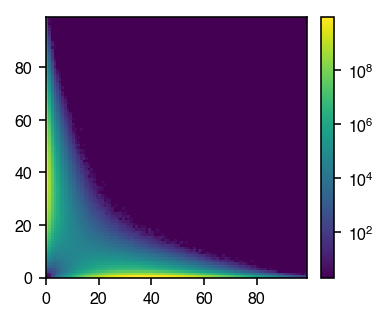

In [4]:
from copy import deepcopy
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

cm = deepcopy(mpl.cm.viridis)
cm.set_bad(mpl.cm.viridis(0))
# cm.set_under(mpl.cm.viridis(0))
# cm.set_over(mpl.cm.viridis(0))
fig,ax = pltHlp.figAx()

# ensure that x vs y scaling doesn't disrupt the transforms applied to the 2D gaussian
ax.set_aspect('equal', 'box')
img = ax.pcolormesh(X,Y,hsum, norm=mpl.colors.LogNorm(), cmap=cm)

# create the colorbar and ensure that it goes from 0 -> 1
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(img, ax=ax, cax=cax)
# cbar.set_ticks([0, .2, .4, .6, .8, 1])

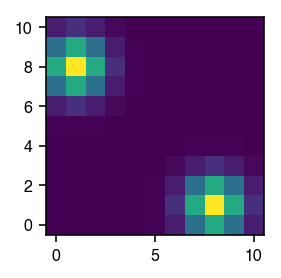

In [50]:
import scipy.stats as sts

X,Y = np.meshgrid(range(11),range(11))
mean = (1,8)
cov = np.eye(2)
Z = sts.multivariate_normal(mean, cov).pdf(np.stack([X,Y],2))

mean = (8,1)
cov = np.eye(2)
Z += sts.multivariate_normal(mean, cov).pdf(np.stack([X,Y],2))

Z = np.around((Z/Z.max())*100, 0)

plt.imshow(Z, origin='lower')